In [ ]:
!pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 4.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=7b648f89d2601d742bee215c80f0d415257042fafe61fd9dbadd58bd5ceab892
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=4e69224417fecd6064d8c3badf8f91dd2d3886bbbd26a95a8ed92509b68fcb75
  Stored in directory: /root/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built pyLDAvis sklearn


In [ ]:
!pip install --upgrade gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.1 MB 65.3 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving NorthAmerica_VaccIntro.csv to NorthAmerica_VaccIntro.csv


In [ ]:
import pandas as pd
import io
from google.colab import files
df = pd.read_csv(io.BytesIO(uploaded['NorthAmerica_VaccIntro.csv']))
df = df.filter(['user_location', 'text', 'created_at'])
clean_df = df.copy()
clean_df = clean_df.rename(columns={'user_location': 'location', 'created_at': 'time'})
clean_df = clean_df.reset_index()
clean_df["time"] = clean_df["time"].astype('datetime64[D]') 
clean_df["time"] = clean_df.time.dt.to_pydatetime()
p_df = clean_df.rename(columns = {'time': 'date'})
p_df.drop('index', inplace=True, axis=1)
print(p_df)

                         location  ...       date
0                     Atlanta, GA  ... 2020-12-30
1                             MTZ  ... 2020-12-30
2                       Ohio, USA  ... 2020-12-30
3                Indianapolis, IN  ... 2020-12-30
4                      Dallas, TX  ... 2020-12-30
...                           ...  ...        ...
46663                         PHL  ... 2021-01-15
46664           Northern Virginia  ... 2021-01-15
46665  New York Brussels Belgium   ... 2021-01-15
46666                         NaN  ... 2021-01-15
46667                         NaN  ... 2021-01-15

[46668 rows x 3 columns]


In [ ]:
import re
import string
def clean_text(text):
  text = text.lower()
  #remove text in square brackets
  text = re.sub(r'\[.*?\]', '', text)
  #remove punctuation   
  text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text) 
  #remove words containing numbers
  text = re.sub(r'\w*\d\w*', '', text)
  return text
p_df = pd.DataFrame(p_df.text.apply(lambda x: clean_text(x)))

In [ ]:
# Import required packages
import pandas as pd
import numpy as np
import logging
import gensim
import json
import warnings
warnings.filterwarnings('ignore')  # To ignore all warnings that arise here to enhance clarity
from pprint import pprint
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
from numpy import array
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
from gensim.utils import simple_preprocess
import io

# Import dataset
#p_df = pd.read_csv("/My Drive/SPROJ (2)/NorthAmerica_VaccIntro.csv")
# Create sample of 10,000 reviews

# Convert to array
docs =array(p_df['text'])
# Define function for tokenize and lemmatizing
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer


def docs_preprocessor(docs):
    tokenizer = RegexpTokenizer(r'\w+')
    for idx in range(len(docs)):
        docs[idx] = docs[idx].lower()  # Convert to lowercase.
        docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.

    # Remove numbers, but not words that contain numbers.
    docs = [[token for token in doc if not token.isdigit()] for doc in docs]
    
    # Remove words that are only one character.
    docs = [[token for token in doc if len(token) > 3] for doc in docs]
    
    # Lemmatize all words in documents.
    lemmatizer = WordNetLemmatizer()
    docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]
    docs = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in docs]
    return docs
# Perform function on our document
docs = docs_preprocessor(docs)
#Create Biagram & Trigram Models 
from gensim.models import Phrases
# Add bigrams and trigrams to docs,minimum count 10 means only that appear 10 times or more.
bigram = Phrases(docs, min_count=10)
trigram = Phrases(bigram[docs])

for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)
    for token in trigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)
#Remove rare & common tokens 
# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)
dictionary.filter_extremes(no_below=10, no_above=0.2)
#Create dictionary and corpus required for Topic Modeling
corpus = [dictionary.doc2bow(doc) for doc in docs]
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))
print(corpus[:1])

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Number of unique tokens: 6336
Number of documents: 46668
[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]]


In [ ]:
# Set parameters.
num_topics = 5
chunksize = 500 
passes = 20 
iterations = 400
eval_every = 1  

# Make a index to word dictionary.
temp = dictionary[0]  # only to "load" the dictionary.
id2word = dictionary.id2token

lda_model = LdaModel(corpus=corpus, id2word=id2word, chunksize=chunksize, \
                       alpha='auto', eta='auto', \
                       iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every)
# Print the Keyword in the 5 topics
print(lda_model.print_topics())

[(0, '0.016*"week" + 0.013*"family" + 0.012*"school" + 0.010*"every" + 0.010*"day" + 0.009*"next" + 0.009*"world" + 0.008*"next_week" + 0.008*"news" + 0.008*"dose"'), (1, '0.068*"vaccine" + 0.019*"case" + 0.019*"today" + 0.017*"death" + 0.016*"state" + 0.015*"first" + 0.014*"vaccination" + 0.011*"county" + 0.010*"home" + 0.009*"coronavirus"'), (2, '0.028*"health" + 0.014*"public_health" + 0.012*"plan" + 0.012*"public" + 0.011*"test" + 0.011*"stay_safe" + 0.011*"safe" + 0.011*"worker" + 0.010*"fighting_stigma" + 0.009*"everyone"'), (3, '0.022*"say" + 0.022*"biden" + 0.019*"million" + 0.018*"vaccine_rollout" + 0.017*"make_sure" + 0.015*"check" + 0.014*"small_business" + 0.012*"last_year" + 0.012*"relief" + 0.012*"administration"'), (4, '0.021*"people" + 0.015*"coronavirus" + 0.014*"covid" + 0.011*"need" + 0.011*"time" + 0.010*"mask" + 0.010*"pandemic" + 0.010*"trump" + 0.010*"like" + 0.009*"year"')]


In [ ]:
# Compute Coherence Score using c_v
coherence_model_lda = CoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.2578893063757654


In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

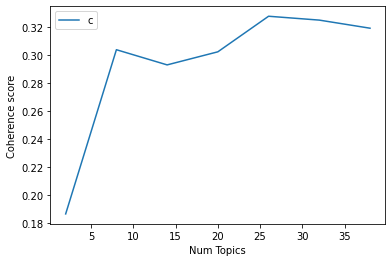

In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=docs, start=2, limit=40, step=6)
# Show graph
import matplotlib.pyplot as plt
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
optimal_model = model_list[1]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.019*"trump" + 0.013*"people" + 0.012*"coronavirus" + 0.011*"next_week" + '
  '0.011*"pandemic" + 0.009*"american" + 0.008*"make_sure" + 0.008*"next" + '
  '0.007*"thing" + 0.007*"life"'),
 (1,
  '0.031*"mask" + 0.028*"wear_mask" + 0.020*"public_health" + 0.017*"wear" + '
  '0.015*"stay_safe" + 0.014*"people" + 0.011*"please" + 0.011*"stay" + '
  '0.009*"safe" + 0.009*"public"'),
 (2,
  '0.029*"death" + 0.023*"case" + 0.020*"tested_positive" + 0.019*"stay_home" '
  '+ 0.012*"positive" + 0.012*"small_business" + 0.011*"home" + '
  '0.011*"coronavirus" + 0.010*"case_death" + 0.010*"healthcare_worker"'),
 (3,
  '0.014*"good" + 0.012*"wearing_mask" + 0.011*"first_dose" + 0.010*"care" + '
  '0.009*"health_care" + 0.009*"good_news" + 0.008*"mask" + 0.007*"capitol" + '
  '0.007*"wearing" + 0.007*"feel_like"'),
 (4,
  '0.022*"health" + 0.016*"fighting_stigma" + 0.010*"coronavirus" + '
  '0.009*"last_year" + 0.008*"fighting" + 0.008*"test_positive" + '
  '0.007*"question" + 0.007*"test

In [ ]:
def add_topic(ldamodel, corpus, df):
  topics = []
  topic_keywords = []
  for i,row in enumerate(ldamodel[corpus]):
    row = sorted(row, key=lambda x: (x[1]), reverse=True)
    for j, (topic_num, prop_topic) in enumerate(row):
      if j==0:
        topic = topic_num
        wp = ldamodel.show_topic(topic_num)
        topic_key = ", ".join([word for word, prop in wp])
        topics.append(topic)
        topic_keywords.append(topic_key)
      else:
        break
  return topics, topic_keywords

topics,keys = add_topic(optimal_model, corpus, p_df)



In [ ]:
intermediate = {'topic':topics, 'topic_keywords':keys}

# Convert dictionary to Pandas dataframe
merge = pd.DataFrame(intermediate)
result_VaccIntro = pd.concat([p_df, merge], axis=1, join="inner")


In [ ]:
print(result_VaccIntro)

                                                    text  ...                                     topic_keywords
0      bruh i’m sorry but kill that nigga i do not ha...  ...  good, wearing_mask, first_dose, care, health_c...
1                     i’m just ready to get out of  tbh   ...  mask, wear_mask, public_health, wear, stay_saf...
2      donwinslow realdonaldtrump i heard we are turn...  ...  mask, wear_mask, public_health, wear, stay_saf...
3                          chase bank dont play with me   ...  mask, wear_mask, public_health, wear, stay_saf...
4      with big events over the next few days arlingt...  ...  trump, people, coronavirus, next_week, pandemi...
...                                                  ...  ...                                                ...
46663                                       warp speed    ...  death, case, tested_positive, stay_home, posit...
46664  you cannot expect him to tell the truth azar n...  ...  good, wearing_mask, first_dose, c

In [ ]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

#Using Vader to find out sentiment of each tweet.
#We will create multiple visualizations from this single column

analyser = SentimentIntensityAnalyzer()

i=0 #counter

compval1 = [ ]  #empty list to hold our computed 'compound' VADER scores


while (i<len(result_VaccIntro)):

    k = analyser.polarity_scores(result_VaccIntro.iloc[i]['text'])
    compval1.append(k['compound'])
    
    i = i+1

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
result_VaccIntro["sentiment"] = compval1

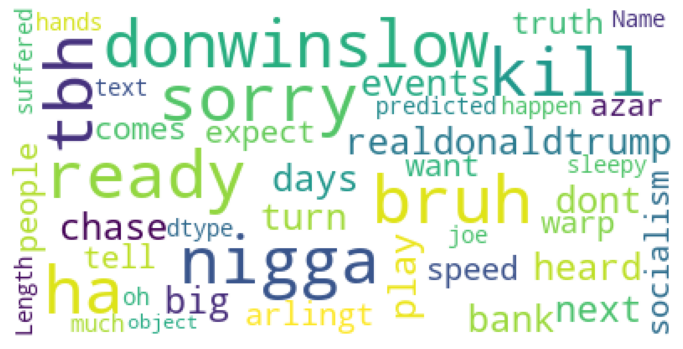

In [ ]:
import matplotlib as mpl
from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS
mpl.rcParams['figure.figsize']=(12.0,12.0)  
mpl.rcParams['font.size']=12            
mpl.rcParams['savefig.dpi']=100             
mpl.rcParams['figure.subplot.bottom']=.1 
stopwords = set(STOPWORDS)
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=500,
                          max_font_size=40, 
                          random_state=100
                         ).generate(str(result_VaccIntro.text))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show();

In [ ]:
print(result_VaccIntro)

                                                    text  ...  sentiment
0      bruh i’m sorry but kill that nigga i do not ha...  ...    -0.8271
1                     i’m just ready to get out of  tbh   ...     0.3612
2      donwinslow realdonaldtrump i heard we are turn...  ...     0.0000
3                          chase bank dont play with me   ...    -0.2584
4      with big events over the next few days arlingt...  ...     0.6597
...                                                  ...  ...        ...
46663                                       warp speed    ...     0.0000
46664  you cannot expect him to tell the truth azar n...  ...    -0.5267
46665  when it comes to   people want socialism as in...  ...     0.0772
46666   predicted this would happen if sleepy joe and...  ...     0.0000
46667  oh no he has suffered so much at the hands of ...  ...    -0.7717

[46668 rows x 4 columns]


Text(0.5, 1.0, 'Sentiment by Topic, 12/30/2020-1/15/2021')

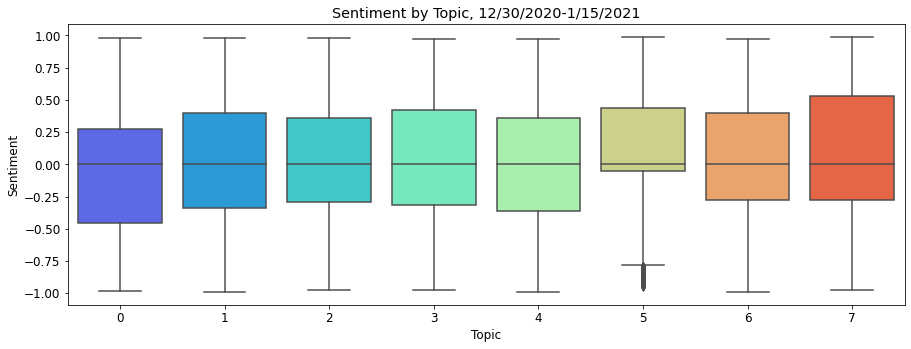

In [ ]:
#The following cells are for visualizing the sentiment in each set of topics we found

import seaborn as sns
plt.figure(figsize=(15,5))
sns.boxplot(x='topic',y='sentiment',data=result_VaccIntro, palette='rainbow')
plt.xlabel("Topic")
plt.ylabel("Sentiment")
plt.title("Sentiment by Topic, 12/30/2020-1/15/2021")

Text(0.5, 1.0, 'Number of tweets by Topic, 12/30/2020-1/15/2021')

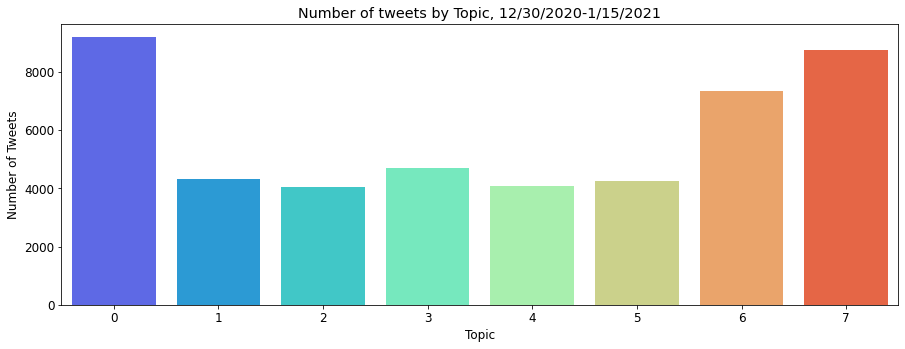

In [ ]:
plt.figure(figsize=(15,5))
ax = sns.countplot(x="topic", data=result_VaccIntro, palette='rainbow')
plt.xlabel("Topic")
plt.ylabel("Number of Tweets")
plt.title("Number of tweets by Topic, 12/30/2020-1/15/2021")

In [ ]:
uploaded = files.upload()

Saving NorthAmerica_Delta to NorthAmerica_Delta


In [ ]:
import pandas as pd
import io
from google.colab import files
df = pd.read_csv(io.BytesIO(uploaded['NorthAmerica_Delta']))
df = df.filter(['user_location', 'text', 'created_at'])
clean_df = df.copy()
clean_df = clean_df.rename(columns={'user_location': 'location', 'created_at': 'time'})
clean_df = clean_df.reset_index()
clean_df["time"] = clean_df["time"].astype('datetime64[D]') 
clean_df["time"] = clean_df.time.dt.to_pydatetime()
p_df2 = clean_df.rename(columns = {'time': 'date'})
p_df2.drop('index', inplace=True, axis=1)
print(p_df2)

              location  ...       date
0           Lothlorien  ... 2021-07-30
1         Florida, USA  ... 2021-07-30
2      California, USA  ... 2021-07-30
3          Raleigh, NC  ... 2021-07-30
4        Arkansas, USA  ... 2021-07-30
...                ...  ...        ...
34028   Miami, FL, USA  ... 2021-08-15
34029        Tulsa, OK  ... 2021-08-15
34030       Racine, WI  ... 2021-08-15
34031       Austin, TX  ... 2021-08-15
34032    Ajax, Ontario  ... 2021-08-15

[34033 rows x 3 columns]


In [ ]:
# Import dataset
# Create sample of 10,000 reviews
p_df2 = pd.DataFrame(p_df2.text.apply(lambda x: clean_text(x)))

# Convert to array
docs2 =array(p_df2['text'])
# Define function for tokenize and lemmatizing
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer


def docs_preprocessor(docs):
    tokenizer = RegexpTokenizer(r'\w+')
    for idx in range(len(docs)):
        docs[idx] = docs[idx].lower()  # Convert to lowercase.
        docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.

    # Remove numbers, but not words that contain numbers.
    docs = [[token for token in doc if not token.isdigit()] for doc in docs]
    
    # Remove words that are only one character.
    docs = [[token for token in doc if len(token) > 3] for doc in docs]
    
    # Lemmatize all words in documents.
    lemmatizer = WordNetLemmatizer()
    docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]
    docs = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in docs]
    return docs
# Perform function on our document
docs2 = docs_preprocessor(docs2)
#Create Biagram & Trigram Models 
from gensim.models import Phrases
# Add bigrams and trigrams to docs,minimum count 10 means only that appear 10 times or more.
bigram = Phrases(docs2, min_count=10)
trigram = Phrases(bigram[docs2])

for idx in range(len(docs2)):
    for token in bigram[docs2[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs2[idx].append(token)
    for token in trigram[docs2[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs2[idx].append(token)
#Remove rare & common tokens 
# Create a dictionary representation of the documents.
dictionary2 = Dictionary(docs2)
dictionary2.filter_extremes(no_below=10, no_above=0.2)
#Create dictionary and corpus required for Topic Modeling
corpus2 = [dictionary2.doc2bow(doc) for doc in docs2]
print('Number of unique tokens: %d' % len(dictionary2))
print('Number of documents: %d' % len(corpus2))
print(corpus2[:1])

Number of unique tokens: 5016
Number of documents: 34033
[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 2), (6, 1), (7, 2), (8, 1)]]


In [ ]:
# Set parameters.
num_topics = 5
chunksize = 500 
passes = 20 
iterations = 400
eval_every = 1  

# Make a index to word dictionary.
temp = dictionary2[0]  # only to "load" the dictionary.
id2word = dictionary2.id2token

lda_model2 = LdaModel(corpus=corpus2, id2word=id2word, chunksize=chunksize, \
                       alpha='auto', eta='auto', \
                       iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every)
# Print the Keyword in the 5 topics
print(lda_model2.print_topics())

[(0, '0.014*"right" + 0.010*"student" + 0.009*"american" + 0.008*"sign" + 0.008*"canada" + 0.008*"science" + 0.008*"better" + 0.008*"leader" + 0.008*"help" + 0.008*"give"'), (1, '0.045*"case" + 0.023*"health" + 0.022*"public_health" + 0.020*"week" + 0.019*"news" + 0.014*"last" + 0.013*"public" + 0.011*"county" + 0.009*"newsbreak" + 0.008*"day"'), (2, '0.030*"covid" + 0.029*"vaccinated" + 0.023*"people" + 0.023*"coronavirus" + 0.020*"delta_variant" + 0.014*"hospital" + 0.013*"state" + 0.012*"delta" + 0.011*"florida" + 0.011*"variant"'), (3, '0.039*"vaccine" + 0.016*"mask" + 0.015*"child" + 0.015*"people" + 0.014*"like" + 0.013*"need" + 0.012*"would" + 0.010*"vaccination" + 0.010*"wear_mask" + 0.010*"good"'), (4, '0.040*"school" + 0.019*"mask_mandate" + 0.019*"federal_provincial" + 0.018*"vaccine_passport" + 0.014*"mandate" + 0.013*"texas" + 0.013*"family" + 0.012*"necessary_canada" + 0.012*"mask" + 0.012*"stop_sign"')]


In [ ]:
# Compute Coherence Score using c_v
coherence_model_lda = CoherenceModel(model=lda_model2, texts=docs2, dictionary=dictionary2, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.28529886659658693


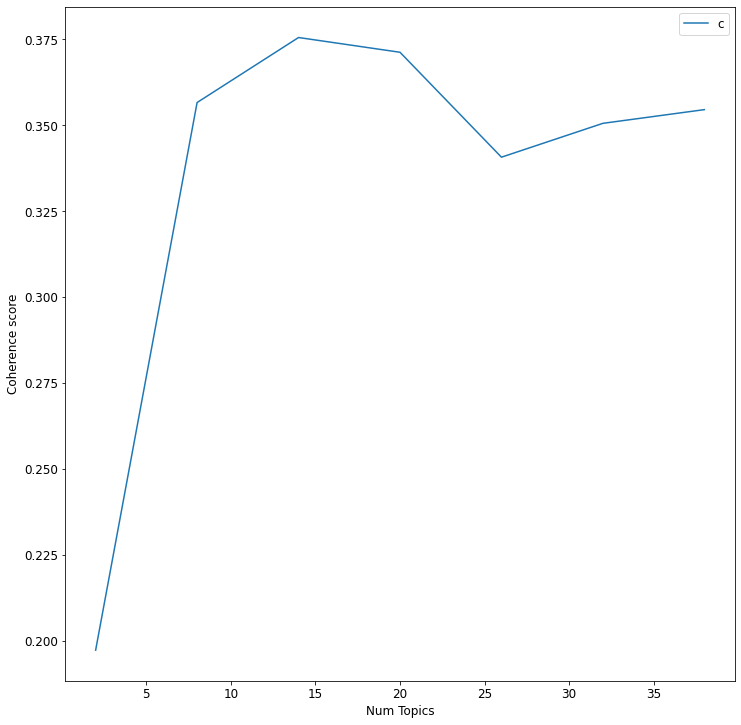

In [ ]:
model_list2, coherence_values2 = compute_coherence_values(dictionary=dictionary2, corpus=corpus2, texts=docs2, start=2, limit=40, step=6)
# Show graph
import matplotlib.pyplot as plt
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values2)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
optimal_model2 = model_list2[1]
model_topics2 = optimal_model2.show_topics(formatted=False)
pprint(optimal_model2.print_topics(num_words=10))

[(0,
  '0.051*"delta_variant" + 0.026*"delta" + 0.023*"variant" + 0.018*"child" + '
  '0.015*"instead" + 0.014*"case" + 0.014*"life" + 0.011*"coronavirus" + '
  '0.009*"death" + 0.009*"held"'),
 (1,
  '0.022*"public_health" + 0.019*"stop_sign" + 0.018*"vaccine" + '
  '0.017*"getting_vaccinated" + 0.013*"vaccinated" + 0.013*"people" + '
  '0.012*"stop" + 0.011*"fully_vaccinated" + 0.010*"health" + '
  '0.010*"provincial"'),
 (2,
  '0.037*"federal_provincial" + 0.030*"vaccine_passport" + '
  '0.024*"necessary_canada" + 0.024*"petition_cdnchange" + 0.016*"case" + '
  '0.015*"passport" + 0.014*"sign" + 0.014*"petition" + 0.013*"necessary" + '
  '0.013*"leader"'),
 (3,
  '0.026*"school" + 0.024*"vaccine" + 0.015*"require_mask" + '
  '0.015*"hospital_bed" + 0.015*"family_friend" + 0.013*"student" + '
  '0.010*"make" + 0.009*"screw" + 0.009*"people" + 0.008*"family"'),
 (4,
  '0.029*"next_month" + 0.020*"lie" + 0.012*"nurse" + 0.012*"twitter" + '
  '0.012*"seems" + 0.011*"next" + 0.011*"super

In [ ]:
topics2,keys2 = add_topic(optimal_model2, corpus2, p_df2)
intermediate2 = {'topic':topics2, 'topic_keywords':keys2}
merge2 = pd.DataFrame(intermediate2)
result_Delta = pd.concat([p_df2, merge2], axis=1, join="inner")
print(result_Delta)

                                                    text  ...                                     topic_keywords
0      hold up  so now theyre not just passively hurt...  ...  good, people, news, literally, think, like, fr...
1      will  vaccination mandates replace mask mandates   ...  mask, wear_mask, mask_mandate, past_week, full...
2      yo leadermcconnell with all disrespect plz…shu...  ...  delta_variant, delta, variant, child, instead,...
3      still evaluating is just a way to dodge the qu...  ...  good, people, news, literally, think, like, fr...
4                            this is just terrible 🥲\n\n  ...  good, people, news, literally, think, like, fr...
...                                                  ...  ...                                                ...
34028  anthonydgale bethanyshondark you cant make fri...  ...  delta_variant, delta, variant, child, instead,...
34029  come on okies let’s get it together httpstcoue...  ...  covid, vaccinated, people, taste_

In [ ]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

#Here we are Analyzing sentiment of another time period i.e. tweets from the Delta variant

analyser = SentimentIntensityAnalyzer()

i=0 #counter

compval2 = [ ]  #empty list to hold our computed 'compound' VADER scores


while (i<len(result_Delta)):

    k = analyser.polarity_scores(result_Delta.iloc[i]['text'])
    compval2.append(k['compound'])
    
    i = i+1

result_Delta["sentiment"] = compval2

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


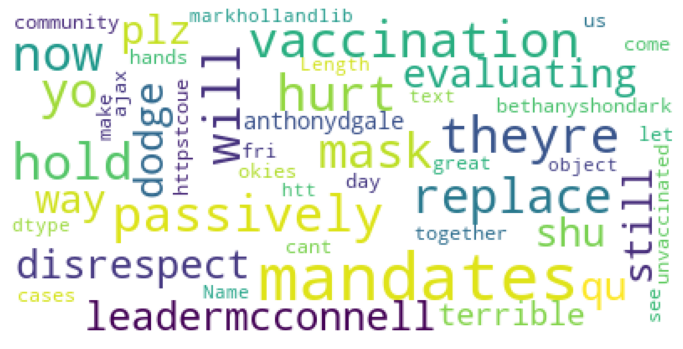

In [ ]:
import matplotlib as mpl
from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS
mpl.rcParams['figure.figsize']=(12.0,12.0)  
mpl.rcParams['font.size']=12            
mpl.rcParams['savefig.dpi']=100             
mpl.rcParams['figure.subplot.bottom']=.1 
stopwords = set(STOPWORDS)
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=300,
                          max_font_size=40, 
                          random_state=100
                         ).generate(str(result_Delta.text))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show();

Text(0.5, 1.0, 'Sentiment by Topic, 7/30/2021-8/15/2021')

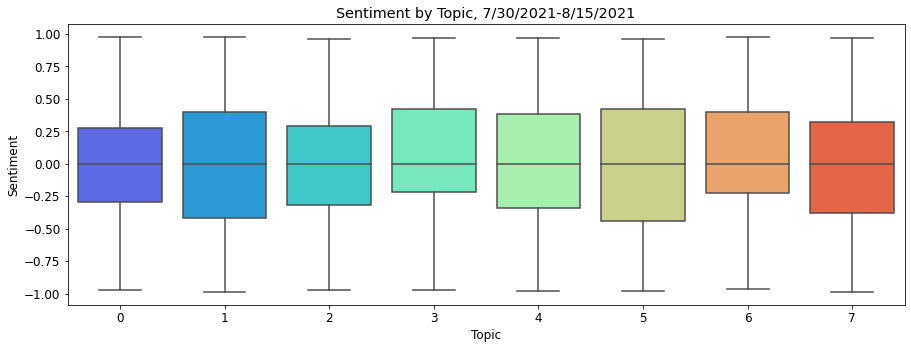

In [ ]:
import seaborn as sns
plt.figure(figsize=(15,5))
sns.boxplot(x='topic',y='sentiment',data=result_Delta, palette='rainbow')
plt.xlabel("Topic")
plt.ylabel("Sentiment")
plt.title("Sentiment by Topic, 7/30/2021-8/15/2021")

Text(0.5, 1.0, 'Number of tweets by Topic, 7/30/2021-8/15/2021')

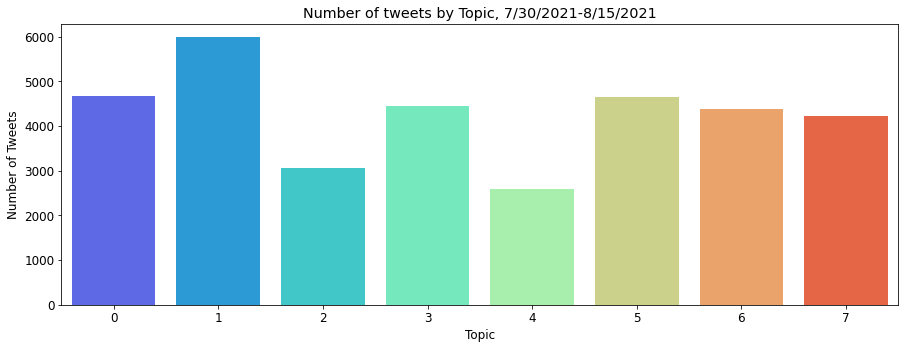

In [ ]:
plt.figure(figsize=(15,5))
ax = sns.countplot(x="topic", data=result_Delta,palette='rainbow')
plt.xlabel("Topic")
plt.ylabel("Number of Tweets")
plt.title("Number of tweets by Topic, 7/30/2021-8/15/2021")

In [ ]:
uploaded = files.upload()

Saving NA_Start to NA_Start


In [ ]:
import pandas as pd
import io
from google.colab import files
df = pd.read_csv(io.BytesIO(uploaded['NA_Start']))
df = df.filter(['user_location', 'text', 'created_at'])
clean_df = df.copy()
clean_df = clean_df.rename(columns={'user_location': 'location', 'created_at': 'time'})
clean_df = clean_df.reset_index()
clean_df["time"] = clean_df["time"].astype('datetime64[D]') 
clean_df["time"] = clean_df.time.dt.to_pydatetime()
p_df3 = clean_df.rename(columns = {'time': 'date'})
p_df3.drop('index', inplace=True, axis=1)
print(p_df3)

                            location  ...       date
0       Corlette NSW 2315, Australia  ... 2020-06-30
1                   CB, Newfoundland  ... 2020-06-30
2                  San Francisco, CA  ... 2020-06-30
3       Corlette NSW 2315, Australia  ... 2020-06-30
4                      Michigan, USA  ... 2020-06-30
...                              ...  ...        ...
136105                           NaN  ... 2020-07-18
136106                Pittsburgh, PA  ... 2020-07-18
136107                 Troy Michigan  ... 2020-07-18
136108              Toronto, Ontario  ... 2020-07-18
136109                      New York  ... 2020-07-18

[136110 rows x 3 columns]


In [ ]:
# Import dataset
# Create sample of 10,000 reviews
p_df3 = pd.DataFrame(p_df3.text.apply(lambda x: clean_text(x)))

# Convert to array
docs3 =array(p_df3['text'])
# Define function for tokenize and lemmatizing
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer


def docs_preprocessor(docs):
    tokenizer = RegexpTokenizer(r'\w+')
    for idx in range(len(docs)):
        docs[idx] = docs[idx].lower()  # Convert to lowercase.
        docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.

    # Remove numbers, but not words that contain numbers.
    docs = [[token for token in doc if not token.isdigit()] for doc in docs]
    
    # Remove words that are only one character.
    docs = [[token for token in doc if len(token) > 3] for doc in docs]
    
    # Lemmatize all words in documents.
    lemmatizer = WordNetLemmatizer()
    docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]
    docs = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in docs]
    return docs
# Perform function on our document
docs3 = docs_preprocessor(docs3)
#Create Biagram & Trigram Models 
from gensim.models import Phrases
# Add bigrams and trigrams to docs,minimum count 10 means only that appear 10 times or more.
bigram = Phrases(docs3, min_count=10)
trigram = Phrases(bigram[docs3])

for idx in range(len(docs3)):
    for token in bigram[docs3[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs3[idx].append(token)
    for token in trigram[docs3[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs3[idx].append(token)
#Remove rare & common tokens 
# Create a dictionary representation of the documents.
dictionary3 = Dictionary(docs3)
dictionary3.filter_extremes(no_below=10, no_above=0.2)
#Create dictionary and corpus required for Topic Modeling
corpus3 = [dictionary3.doc2bow(doc) for doc in docs3]
print('Number of unique tokens: %d' % len(dictionary3))
print('Number of documents: %d' % len(corpus3))
print(corpus3[:1])

Number of unique tokens: 13438
Number of documents: 136110
[[(0, 1), (1, 2), (2, 1), (3, 2), (4, 1), (5, 1), (6, 2), (7, 1), (8, 1), (9, 1), (10, 1), (11, 2), (12, 2), (13, 1), (14, 2), (15, 1), (16, 1), (17, 2), (18, 1), (19, 1), (20, 1), (21, 1), (22, 2), (23, 1), (24, 1), (25, 1), (26, 2), (27, 1), (28, 1), (29, 1), (30, 2), (31, 1), (32, 1), (33, 1), (34, 1), (35, 2), (36, 1), (37, 1), (38, 1), (39, 2), (40, 2)]]


In [ ]:
# Set parameters.
num_topics = 5
chunksize = 500 
passes = 20 
iterations = 400
eval_every = 1  

# Make a index to word dictionary.
temp = dictionary3[0]  # only to "load" the dictionary.
id2word = dictionary3.id2token

lda_model3 = LdaModel(corpus=corpus3, id2word=id2word, chunksize=chunksize, \
                       alpha='auto', eta='auto', \
                       iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every)
# Print the Keyword in the 5 topics
print(lda_model3.print_topics())

[(0, '0.026*"coronavirus" + 0.020*"mask" + 0.017*"people" + 0.015*"trump" + 0.014*"wear_mask" + 0.011*"school" + 0.011*"like" + 0.009*"pandemic" + 0.008*"need" + 0.008*"time"'), (1, '0.027*"case" + 0.020*"coronavirus" + 0.019*"death" + 0.019*"state" + 0.014*"wearing_mask" + 0.014*"health" + 0.012*"number" + 0.011*"county" + 0.010*"data" + 0.010*"tested_positive"'), (2, '0.012*"vaccine" + 0.011*"thank" + 0.010*"never" + 0.008*"face" + 0.007*"free" + 0.007*"contact_tracing" + 0.007*"nothing" + 0.006*"teacher" + 0.006*"story" + 0.006*"call"'), (3, '0.027*"work" + 0.014*"support" + 0.013*"business" + 0.012*"united_state" + 0.011*"done" + 0.010*"hand" + 0.009*"nation" + 0.009*"save" + 0.009*"local" + 0.009*"hard"'), (4, '0.015*"test" + 0.013*"still" + 0.013*"testing" + 0.012*"please" + 0.010*"week" + 0.010*"home" + 0.010*"positive" + 0.008*"hospital" + 0.008*"safe" + 0.007*"stay"')]


In [ ]:
# Compute Coherence Score using c_v
coherence_model_lda = CoherenceModel(model=lda_model3, texts=docs3, dictionary=dictionary3, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.32582347597662875


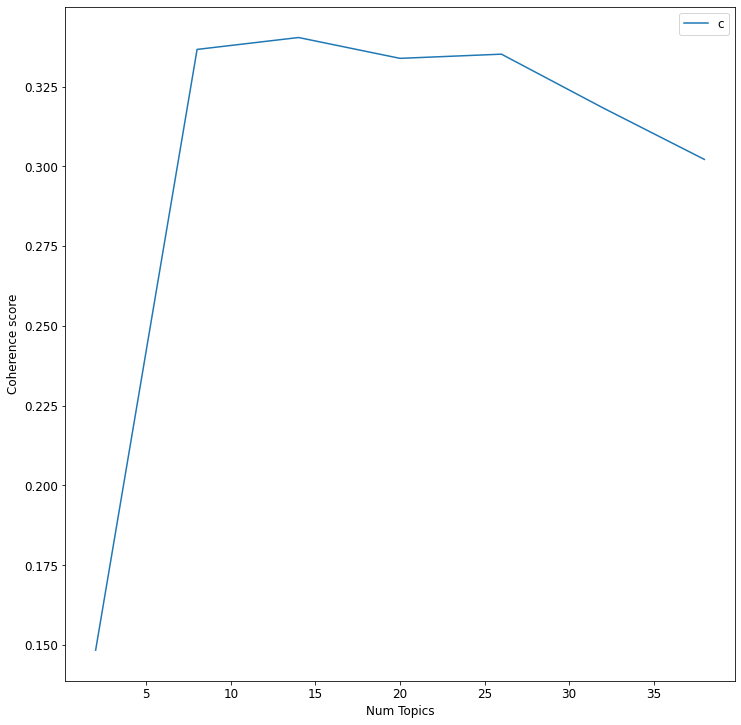

In [ ]:
model_list3, coherence_values3 = compute_coherence_values(dictionary=dictionary3, corpus=corpus3, texts=docs3, start=2, limit=40, step=6)
# Show graph
import matplotlib.pyplot as plt
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values3)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
optimal_model3 = model_list3[1]
model_topics3 = optimal_model3.show_topics(formatted=False)
pprint(optimal_model3.print_topics(num_words=10))

[(0,
  '0.031*"wearing_mask" + 0.024*"mask" + 0.021*"infant_tested" + '
  '0.016*"wearing" + 0.013*"united_state" + 0.012*"state" + '
  '0.012*"social_distancing" + 0.011*"social" + 0.010*"infant" + '
  '0.008*"coronavirus"'),
 (1,
  '0.023*"tested" + 0.021*"tested_positive" + 0.013*"positive" + '
  '0.009*"people" + 0.008*"coronavirus" + 0.008*"safe" + 0.007*"stay_safe" + '
  '0.007*"know" + 0.007*"ignored_destitute" + 0.006*"wash_hand"'),
 (2,
  '0.018*"coronavirus" + 0.010*"fighting_stigma" + 0.009*"health" + '
  '0.009*"pandemic" + 0.006*"july" + 0.006*"relief_package" + 0.006*"fighting" '
  '+ 0.006*"update" + 0.006*"county" + 0.006*"billion_dollar"'),
 (3,
  '0.018*"trump" + 0.015*"school" + 0.010*"coronavirus" + 0.010*"kid" + '
  '0.009*"child" + 0.008*"people" + 0.007*"want" + 0.007*"realdonaldtrump" + '
  '0.007*"contact_tracing" + 0.007*"american"'),
 (4,
  '0.014*"coronavirus" + 0.012*"time" + 0.009*"people" + 0.008*"trump" + '
  '0.008*"need" + 0.008*"think" + 0.007*"like" 

In [ ]:
topics3,keys3 = add_topic(optimal_model3, corpus3, p_df3)
intermediate3 = {'topic':topics3, 'topic_keywords':keys3}
merge3 = pd.DataFrame(intermediate3)
result_Start = pd.concat([p_df3, merge3], axis=1, join="inner")
print(result_Start)

                                                     text  ...                                     topic_keywords
0       nycmayorsoffice please be vigilant with cruise...  ...  trump, school, coronavirus, kid, child, people...
1       readinstead meghanmccain how else are you goin...  ...  tested, tested_positive, positive, people, cor...
2       here we gooklahoma had a   positive rate past ...  ...  case, coronavirus, death, florida, state, test...
3       alaskadhss please be vigilant with cruise ship...  ...  trump, school, coronavirus, kid, child, people...
4                                         hog wash mitch   ...  tested, tested_positive, positive, people, cor...
...                                                   ...  ...                                                ...
136105                                              amen   ...  wearing_mask, mask, infant_tested, wearing, un...
136106  just ordered two\n🎶🙏📮🙏🎶\ncheers guys\nhacketto...  ...  case, coronavirus, death

In [ ]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

#Finally, we analyze sentiment of tweets from the start of the pandemic

analyser = SentimentIntensityAnalyzer()

i=0 #counter

compval3 = [ ]  #empty list to hold our computed 'compound' VADER scores


while (i<len(result_Start)):

    k = analyser.polarity_scores(result_Start.iloc[i]['text'])
    compval3.append(k['compound'])
    
    i = i+1

result_Start["sentiment"] = compval3

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


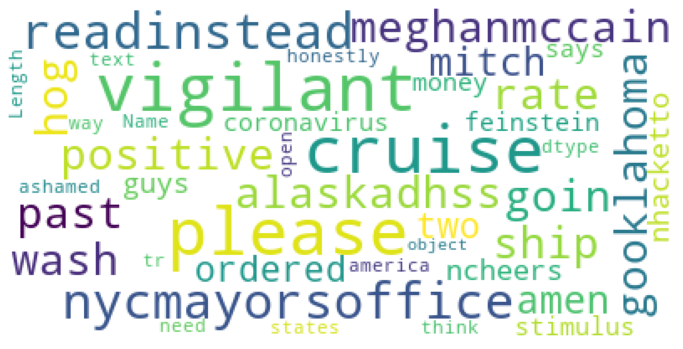

In [ ]:
import matplotlib as mpl
from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS
mpl.rcParams['figure.figsize']=(12.0,12.0)  
mpl.rcParams['font.size']=12            
mpl.rcParams['savefig.dpi']=100             
mpl.rcParams['figure.subplot.bottom']=.1 
stopwords = set(STOPWORDS)
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=300,
                          max_font_size=40, 
                          random_state=100
                         ).generate(str(result_Start.text))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show();

Text(0.5, 1.0, 'Sentiment by Topic, 6/30/2020-7/18/2020')

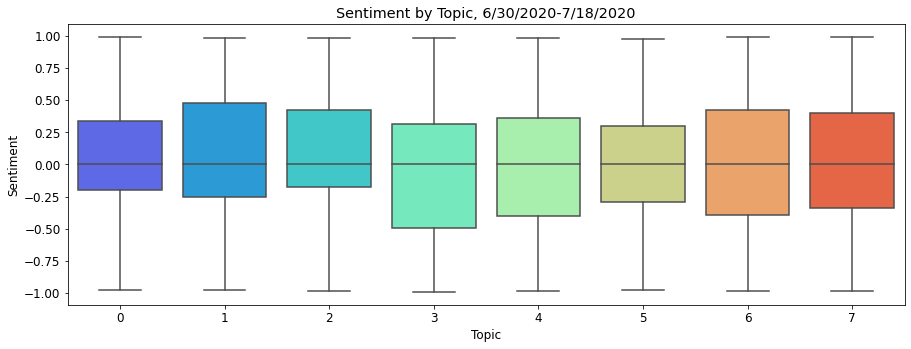

In [ ]:
import seaborn as sns
plt.figure(figsize=(15,5))
sns.boxplot(x='topic',y='sentiment',data=result_Start, palette='rainbow')
plt.xlabel("Topic")
plt.ylabel("Sentiment")
plt.title("Sentiment by Topic, 6/30/2020-7/18/2020")

Text(0.5, 1.0, 'Number of tweets by Topic, 6/30/2020-7/18/2020')

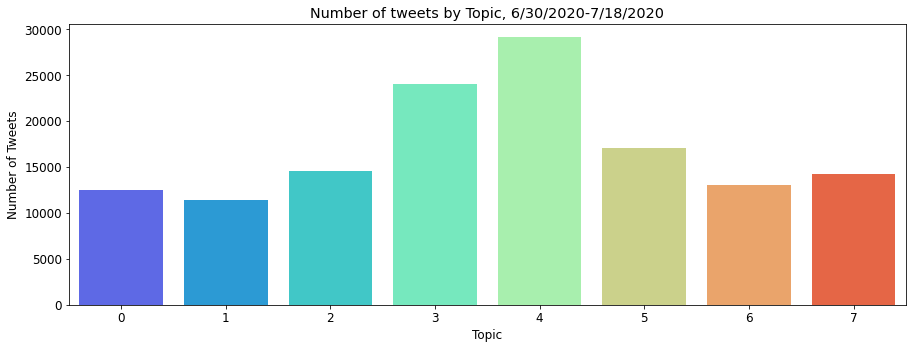

In [ ]:
plt.figure(figsize=(15,5))
ax = sns.countplot(x="topic", data=result_Start,palette='rainbow')
plt.xlabel("Topic")
plt.ylabel("Number of Tweets")
plt.title("Number of tweets by Topic, 6/30/2020-7/18/2020")

In [ ]:
path = "/content/NorthAmerica_VaccIntro.csv"

In [ ]:
p_df = pd.read_csv(path)
p_df = p_df.filter(['user_location', 'text', 'created_at'])
p_df = p_df.copy()
p_df = p_df.rename(columns={'user_location': 'location', 'created_at': 'time'})
p_df = p_df.reset_index()
p_df["time"] = p_df["time"].astype('datetime64[D]') 
p_df["time"] = p_df.time.dt.to_pydatetime()
p_df = p_df.rename(columns = {'time': 'date'})
p_df.drop('index', inplace=True, axis=1)
print(p_df)

                         location  ...       date
0                     Atlanta, GA  ... 2020-12-30
1                             MTZ  ... 2020-12-30
2                       Ohio, USA  ... 2020-12-30
3                Indianapolis, IN  ... 2020-12-30
4                      Dallas, TX  ... 2020-12-30
...                           ...  ...        ...
46663                         PHL  ... 2021-01-15
46664           Northern Virginia  ... 2021-01-15
46665  New York Brussels Belgium   ... 2021-01-15
46666                         NaN  ... 2021-01-15
46667                         NaN  ... 2021-01-15

[46668 rows x 3 columns]


In [ ]:
path2 = "/content/NorthAmerica_Delta"

In [ ]:
p_df2 = pd.read_csv(path2)
p_df2 = p_df2.filter(['user_location', 'text', 'created_at'])
p_df2 = p_df2.copy()
p_df2 = p_df2.rename(columns={'user_location': 'location', 'created_at': 'time'})
p_df2 = p_df2.reset_index()
p_df2["time"] = p_df2["time"].astype('datetime64[D]') 
p_df2["time"] = p_df2.time.dt.to_pydatetime()
p_df2 = p_df2.rename(columns = {'time': 'date'})
p_df2.drop('index', inplace=True, axis=1)
print(p_df2)

              location  ...       date
0           Lothlorien  ... 2021-07-30
1         Florida, USA  ... 2021-07-30
2      California, USA  ... 2021-07-30
3          Raleigh, NC  ... 2021-07-30
4        Arkansas, USA  ... 2021-07-30
...                ...  ...        ...
34028   Miami, FL, USA  ... 2021-08-15
34029        Tulsa, OK  ... 2021-08-15
34030       Racine, WI  ... 2021-08-15
34031       Austin, TX  ... 2021-08-15
34032    Ajax, Ontario  ... 2021-08-15

[34033 rows x 3 columns]


In [ ]:
path3 = "/content/NA_Start"

In [ ]:
p_df3 = pd.read_csv(path3)
p_df3 = p_df3.filter(['user_location', 'text', 'created_at'])
p_df3 = p_df3.copy()
p_df3 = p_df3.rename(columns={'user_location': 'location', 'created_at': 'time'})
p_df3 = p_df3.reset_index()
p_df3["time"] = p_df3["time"].astype('datetime64[D]') 
p_df3["time"] = p_df3.time.dt.to_pydatetime()
p_df3 = p_df3.rename(columns = {'time': 'date'})
p_df3.drop('index', inplace=True, axis=1)
print(p_df3)

                            location  ...       date
0       Corlette NSW 2315, Australia  ... 2020-06-30
1                   CB, Newfoundland  ... 2020-06-30
2                  San Francisco, CA  ... 2020-06-30
3       Corlette NSW 2315, Australia  ... 2020-06-30
4                      Michigan, USA  ... 2020-06-30
...                              ...  ...        ...
136105                           NaN  ... 2020-07-18
136106                Pittsburgh, PA  ... 2020-07-18
136107                 Troy Michigan  ... 2020-07-18
136108              Toronto, Ontario  ... 2020-07-18
136109                      New York  ... 2020-07-18

[136110 rows x 3 columns]


In [ ]:
!pip uninstall numpy -y
!pip install numpy==1.20.1

!pip uninstall pandas -y
!pip install pandas==1.2.2

In [ ]:
dataset1 = np.full(result_VaccIntro.shape[0], 'Vaccines').tolist()
topic1 = result_VaccIntro['topic'].tolist()
tweet1 = result_VaccIntro['text'].tolist()
sentiment1 = compval1
print(p_df)
date1 = p_df['date'].tolist()
date1
dict = {'dataset': dataset1, 'topic': topic1, 'text': tweet1, 'date': date1, 'sentiment': sentiment1} 
    
df = pd.DataFrame(dict)
    
print(df) 

                         location  ...       date
0                     Atlanta, GA  ... 2020-12-30
1                             MTZ  ... 2020-12-30
2                       Ohio, USA  ... 2020-12-30
3                Indianapolis, IN  ... 2020-12-30
4                      Dallas, TX  ... 2020-12-30
...                           ...  ...        ...
46663                         PHL  ... 2021-01-15
46664           Northern Virginia  ... 2021-01-15
46665  New York Brussels Belgium   ... 2021-01-15
46666                         NaN  ... 2021-01-15
46667                         NaN  ... 2021-01-15

[46668 rows x 3 columns]
        dataset  topic  ...       date sentiment
0      Vaccines      3  ... 2020-12-30   -0.8271
1      Vaccines      1  ... 2020-12-30    0.3612
2      Vaccines      1  ... 2020-12-30    0.0000
3      Vaccines      1  ... 2020-12-30   -0.2584
4      Vaccines      0  ... 2020-12-30    0.6597
...         ...    ...  ...        ...       ...
46663  Vaccines      2  ... 202

In [ ]:
dataset2 = np.full(result_Delta.shape[0], 'Delta').tolist()
topic2 = result_Delta['topic'].tolist()
tweet2 = result_Delta['text'].tolist()
sentiment2 = compval2
print(p_df2)
date2 = p_df2['date'].tolist()
date2
dict2 = {'dataset': dataset2, 'topic': topic2, 'text': tweet2, 'date': date2, 'sentiment': sentiment2} 
    
df2 = pd.DataFrame(dict2)
    
print(df2)

              location  ...       date
0           Lothlorien  ... 2021-07-30
1         Florida, USA  ... 2021-07-30
2      California, USA  ... 2021-07-30
3          Raleigh, NC  ... 2021-07-30
4        Arkansas, USA  ... 2021-07-30
...                ...  ...        ...
34028   Miami, FL, USA  ... 2021-08-15
34029        Tulsa, OK  ... 2021-08-15
34030       Racine, WI  ... 2021-08-15
34031       Austin, TX  ... 2021-08-15
34032    Ajax, Ontario  ... 2021-08-15

[34033 rows x 3 columns]
      dataset  topic  ...       date sentiment
0       Delta      5  ... 2021-07-30   -0.4261
1       Delta      6  ... 2021-07-30    0.0000
2       Delta      0  ... 2021-07-30   -0.9349
3       Delta      5  ... 2021-07-30    0.0000
4       Delta      5  ... 2021-07-30   -0.4767
...       ...    ...  ...        ...       ...
34028   Delta      0  ... 2021-08-15   -0.8821
34029   Delta      7  ... 2021-08-15    0.0000
34030   Delta      1  ... 2021-08-15    0.0000
34031   Delta      2  ... 2021-08-15

In [ ]:
dataset3 = np.full(result_Start.shape[0], 'Start').tolist()
topic3 = result_Start['topic'].tolist()
tweet3 = result_Start['text'].tolist()
sentiment3 = compval3
print(p_df3)
date3 = p_df3['date'].tolist()
date3
dict3 = {'dataset': dataset3, 'topic': topic3, 'text': tweet3, 'date': date3, 'sentiment': sentiment3} 
    
df3 = pd.DataFrame(dict3)
    
print(df3)

                            location  ...       date
0       Corlette NSW 2315, Australia  ... 2020-06-30
1                   CB, Newfoundland  ... 2020-06-30
2                  San Francisco, CA  ... 2020-06-30
3       Corlette NSW 2315, Australia  ... 2020-06-30
4                      Michigan, USA  ... 2020-06-30
...                              ...  ...        ...
136105                           NaN  ... 2020-07-18
136106                Pittsburgh, PA  ... 2020-07-18
136107                 Troy Michigan  ... 2020-07-18
136108              Toronto, Ontario  ... 2020-07-18
136109                      New York  ... 2020-07-18

[136110 rows x 3 columns]
       dataset  topic  ...       date sentiment
0        Start      3  ... 2020-06-30    0.1531
1        Start      1  ... 2020-06-30    0.6002
2        Start      5  ... 2020-06-30   -0.0772
3        Start      3  ... 2020-06-30    0.1531
4        Start      1  ... 2020-06-30    0.0000
...        ...    ...  ...        ...       ...
1

In [ ]:
pdList = [df, df2, df3]  # List of your dataframes
main_df = pd.concat(pdList)
print(main_df)

         dataset  topic  ...       date sentiment
0       Vaccines      3  ... 2020-12-30   -0.8271
1       Vaccines      1  ... 2020-12-30    0.3612
2       Vaccines      1  ... 2020-12-30    0.0000
3       Vaccines      1  ... 2020-12-30   -0.2584
4       Vaccines      0  ... 2020-12-30    0.6597
...          ...    ...  ...        ...       ...
136105     Start      0  ... 2020-07-18    0.0000
136106     Start      5  ... 2020-07-18    0.4767
136107     Start      7  ... 2020-07-18   -0.2960
136108     Start      3  ... 2020-07-18    0.3818
136109     Start      4  ... 2020-07-18    0.1027

[216811 rows x 5 columns]


In [ ]:
!pip uninstall pandas
!pip install pandas==1.1.5

Found existing installation: pandas 1.3.5
Uninstalling pandas-1.3.5:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/pandas-1.3.5.dist-info/*
    /usr/local/lib/python3.7/dist-packages/pandas/*
Proceed (y/n)? y
  Successfully uninstalled pandas-1.3.5
     |████████████████████████████████| 9.5 MB 5.4 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyldavis 3.3.1 requires pandas>=1.2.0, but you have pandas 1.1.5 which is incompatible.


In [ ]:
#compression_opts = dict(method='zip',archive_name='out.csv')  
main_df.to_csv("/content/main_df.csv") 

In [ ]:
pip install pandas --upgrade

In [ ]:
main_df.shape

(216811, 5)

In [ ]:
print(main_df.loc[main_df['dataset']=='Vaccines'])
print(main_df.loc[main_df['dataset']=='Delta'])

        dataset  topic  ...       date sentiment
0      Vaccines      3  ... 2020-12-30   -0.8271
1      Vaccines      1  ... 2020-12-30    0.3612
2      Vaccines      1  ... 2020-12-30    0.0000
3      Vaccines      1  ... 2020-12-30   -0.2584
4      Vaccines      0  ... 2020-12-30    0.6597
...         ...    ...  ...        ...       ...
46663  Vaccines      2  ... 2021-01-15    0.0000
46664  Vaccines      3  ... 2021-01-15   -0.5267
46665  Vaccines      7  ... 2021-01-15    0.0772
46666  Vaccines      0  ... 2021-01-15    0.0000
46667  Vaccines      7  ... 2021-01-15   -0.7717

[46668 rows x 5 columns]
      dataset  topic  ...       date sentiment
0       Delta      5  ... 2021-07-30   -0.4261
1       Delta      6  ... 2021-07-30    0.0000
2       Delta      0  ... 2021-07-30   -0.9349
3       Delta      5  ... 2021-07-30    0.0000
4       Delta      5  ... 2021-07-30   -0.4767
...       ...    ...  ...        ...       ...
34028   Delta      0  ... 2021-08-15   -0.8821
34029   De

Text(0.5, 1.0, 'Violin Plot of Sentiment by Time Period')

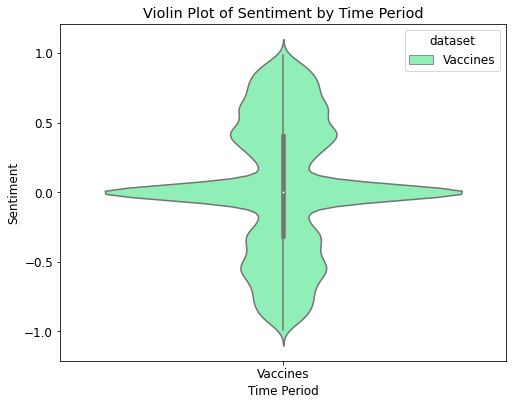

In [ ]:
plt.figure(figsize=(8,6))
sns.violinplot(x="dataset",y="sentiment",data=main_df.loc[main_df['dataset']=='Vaccines'], hue='dataset',palette='rainbow')
plt.xlabel("Time Period")
plt.ylabel("Sentiment")
plt.title("Violin Plot of Sentiment by Time Period")

Text(0.5, 1.0, 'Violin Plot of Sentiment by Time Period')

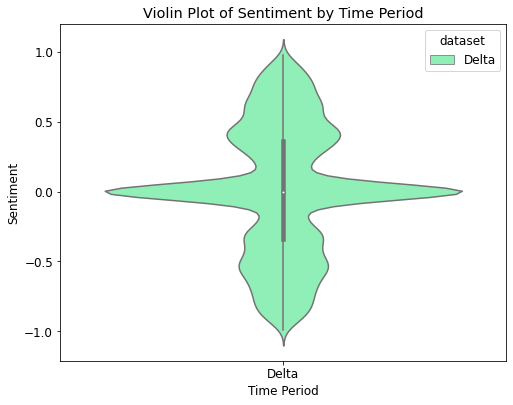

In [ ]:
plt.figure(figsize=(8,6))
sns.violinplot(x="dataset",y="sentiment",data=main_df.loc[main_df['dataset']=='Delta'], hue='dataset',palette='rainbow')
plt.xlabel("Time Period")
plt.ylabel("Sentiment")
plt.title("Violin Plot of Sentiment by Time Period")

Text(0.5, 1.0, 'Violin Plot of Sentiment by Time Period')

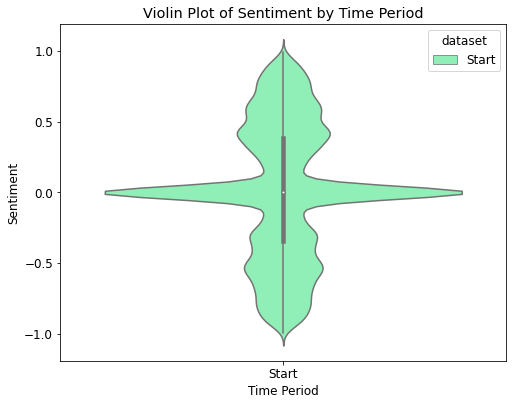

In [ ]:
plt.figure(figsize=(8,6))
sns.violinplot(x="dataset",y="sentiment",data=main_df.loc[main_df['dataset']=='Start'], hue='dataset',palette='rainbow')
plt.xlabel("Time Period")
plt.ylabel("Sentiment")
plt.title("Violin Plot of Sentiment by Time Period")

Text(0.5, 1.0, 'Violin Plot of Sentiment by Time Period')

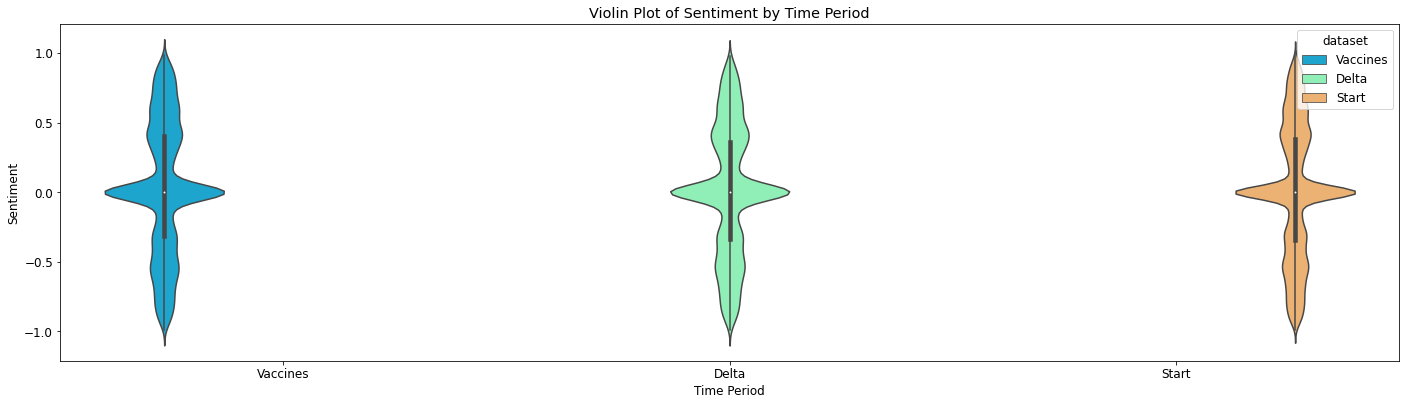

In [ ]:
import seaborn as sns
plt.figure(figsize=(24,6))
sns.violinplot(x="dataset",y="sentiment",data=main_df, hue='dataset',palette='rainbow')
plt.xlabel("Time Period")
plt.ylabel("Sentiment")
plt.title("Violin Plot of Sentiment by Time Period")

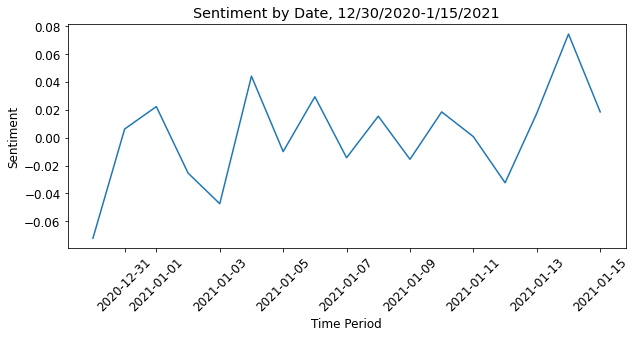

In [ ]:
#Drawing lineplot of sentiment vs. time
plt.figure(figsize=(10,4))
mean_df = df.groupby(['date','sentiment'])['sentiment'].mean()
sns.lineplot(x="date", y="sentiment", data=mean_df, ci=None)
plt.xlabel("Time Period")
plt.ylabel("Sentiment")
plt.title("Sentiment by Date, 12/30/2020-1/15/2021")
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.show()

Text(0.5, 1.0, 'Number of positive tweets by Topic, January 1 2021')

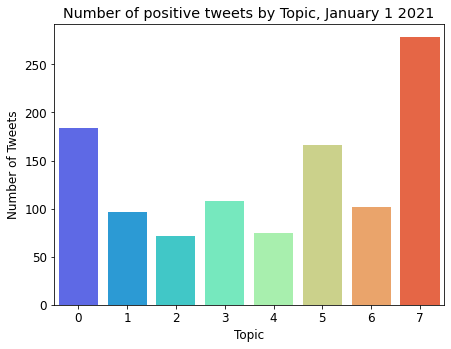

In [ ]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x="topic", data=main_df.loc[(main_df['date'] == '2021-01-01') & (main_df['sentiment'] > 0)],palette='rainbow')
plt.xlabel("Topic")
plt.ylabel("Number of Tweets")
plt.title("Number of positive tweets by Topic, January 1 2021")

Text(0.5, 1.0, 'Number of negative tweets by Topic, January 3rd 2021')

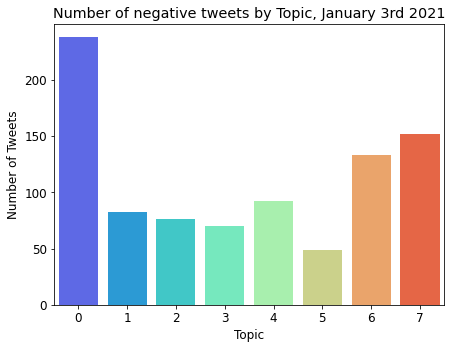

In [ ]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x="topic", data=main_df.loc[(main_df['date'] == '2021-01-03') & (main_df['sentiment'] < 0)],palette='rainbow')
plt.xlabel("Topic")
plt.ylabel("Number of Tweets")
plt.title("Number of negative tweets by Topic, January 3rd 2021")

Text(0.5, 1.0, 'Number of positive tweets by Topic, January 12th 2021')

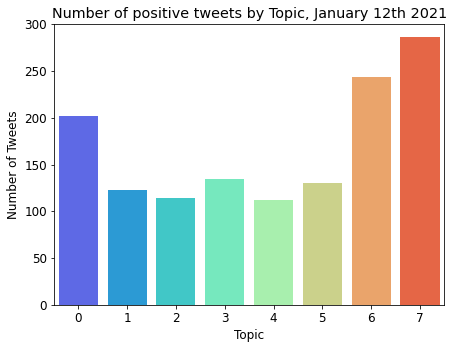

In [ ]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x="topic", data=main_df.loc[(main_df['date'] == '2021-01-12') & (main_df['sentiment'] > 0)],palette='rainbow')
plt.xlabel("Topic")
plt.ylabel("Number of Tweets")
plt.title("Number of positive tweets by Topic, January 12th 2021")

Text(0.5, 1.0, 'Number of negative tweets by Topic, January 14th 2021')

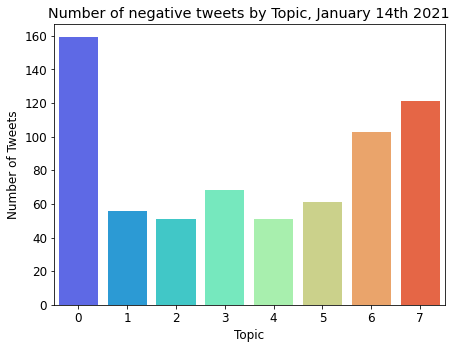

In [ ]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x="topic", data=main_df.loc[(main_df['date'] == '2021-01-14') & (main_df['sentiment'] < 0)],palette='rainbow')
plt.xlabel("Topic")
plt.ylabel("Number of Tweets")
plt.title("Number of negative tweets by Topic, January 14th 2021")

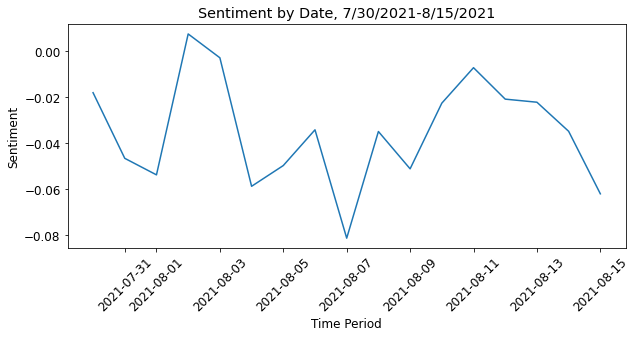

In [ ]:
plt.figure(figsize=(10,4))
mean_df2 = df2.groupby(['date','sentiment'])['sentiment'].mean()
sns.lineplot(x="date", y="sentiment", data=mean_df2, ci=None)
plt.xlabel("Time Period")
plt.ylabel("Sentiment")
plt.title("Sentiment by Date, 7/30/2021-8/15/2021")
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.show()

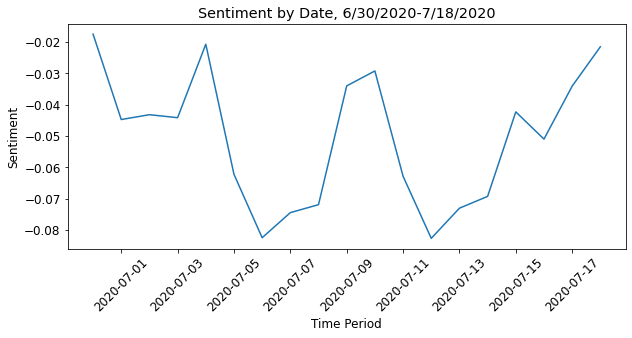

In [ ]:
# draw lineplot
plt.figure(figsize=(10,4))
mean_df3 = df3.groupby(['date','sentiment'])['sentiment'].mean()
sns.lineplot(x="date", y="sentiment", data=mean_df3, ci=None)
plt.xlabel("Time Period")
plt.ylabel("Sentiment")
plt.title("Sentiment by Date, 6/30/2020-7/18/2020")
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.show()

Vaccines  Topic  0


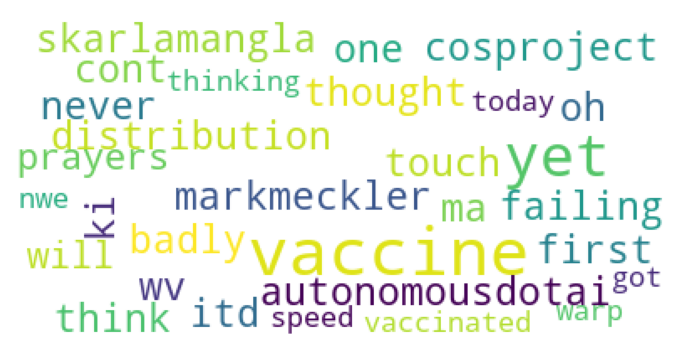

Vaccines  Topic  1


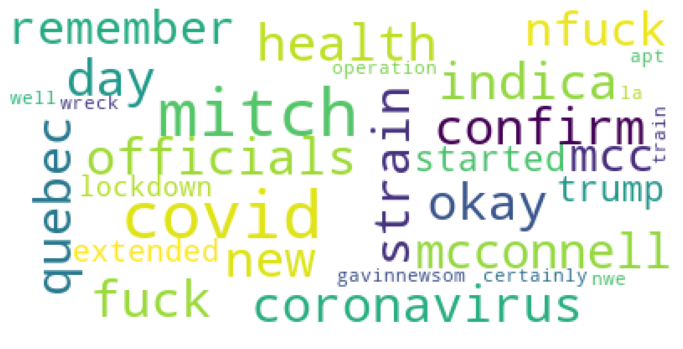

Vaccines  Topic  2


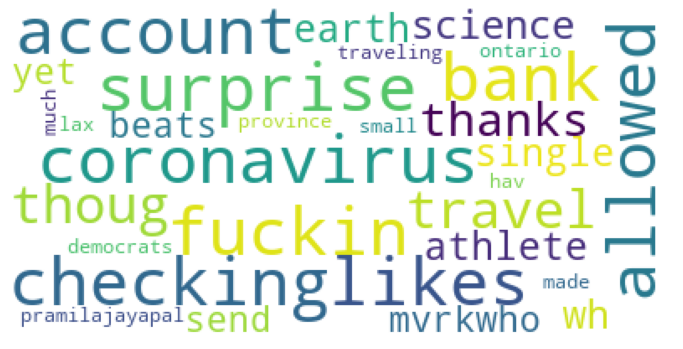

Vaccines  Topic  3


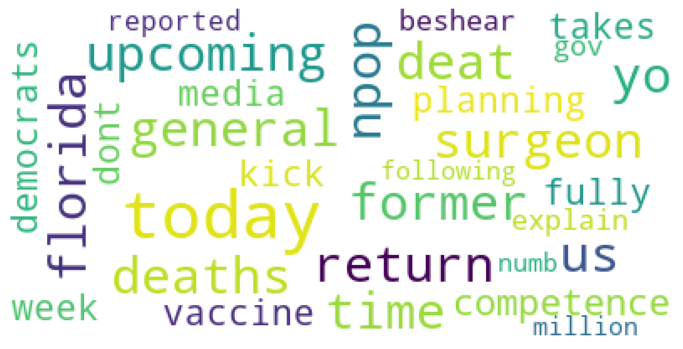

Vaccines  Topic  4


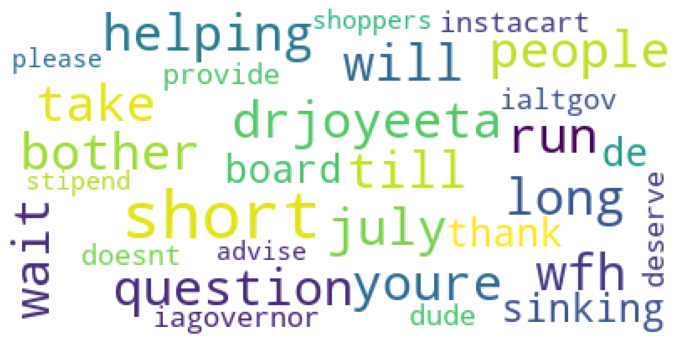

Vaccines  Topic  5


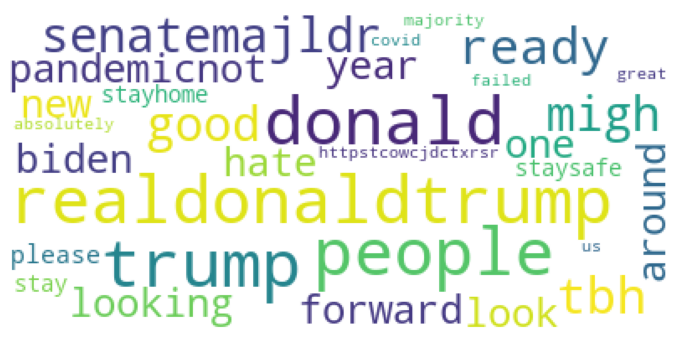

Vaccines  Topic  6


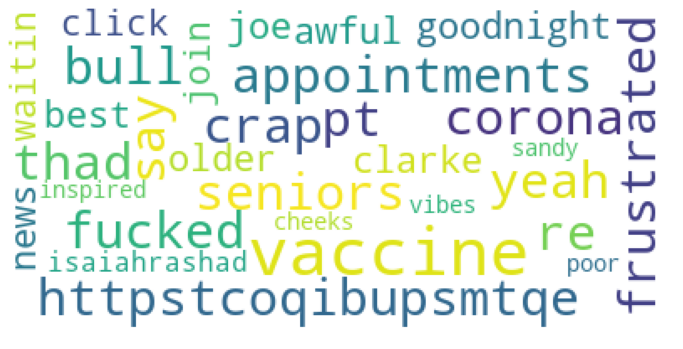

Vaccines  Topic  7


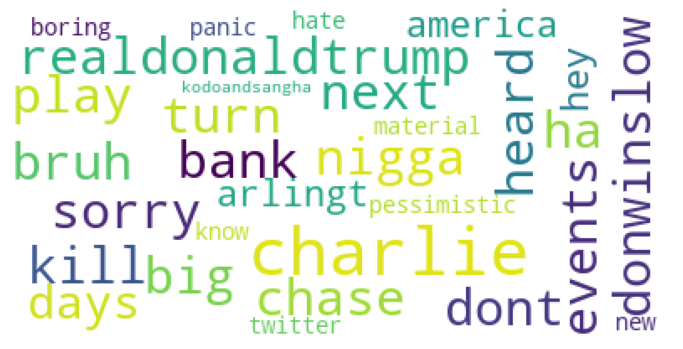

Delta  Topic  0


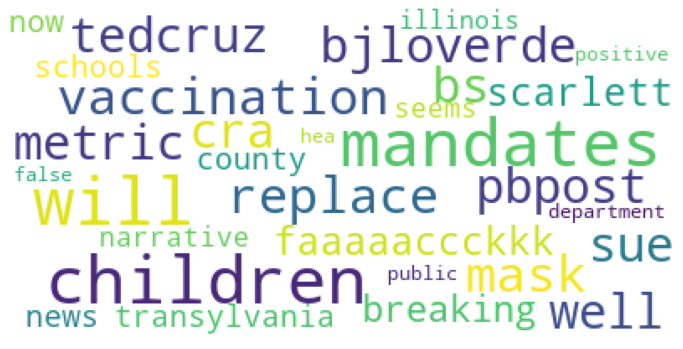

Delta  Topic  1


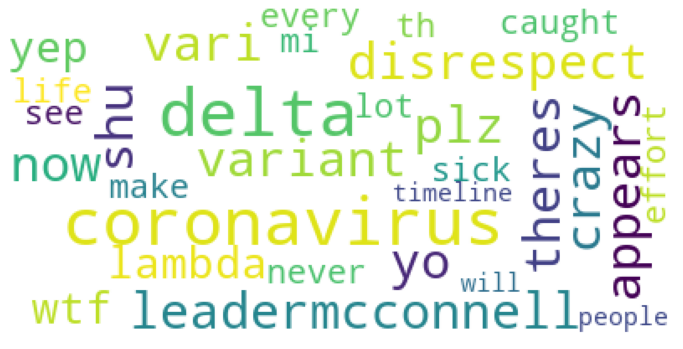

Delta  Topic  2


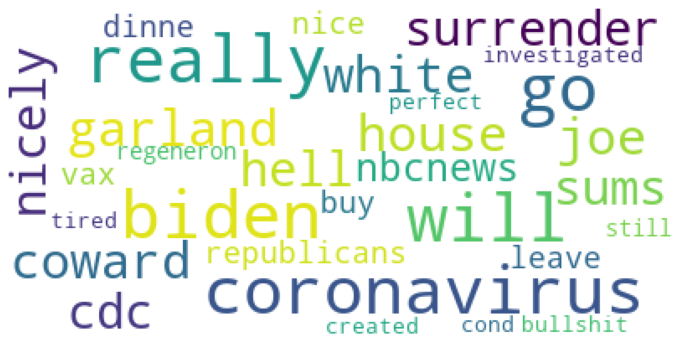

Delta  Topic  3


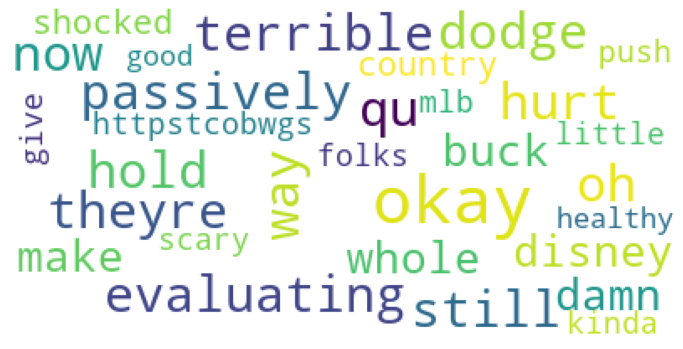

Delta  Topic  4


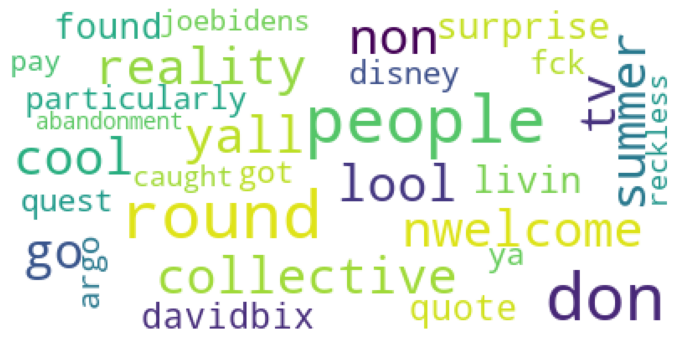

Delta  Topic  5


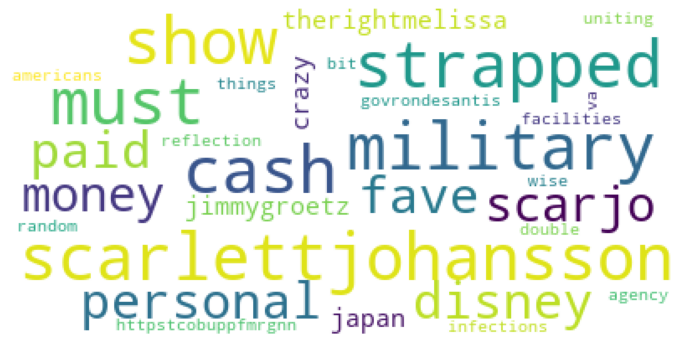

Delta  Topic  6


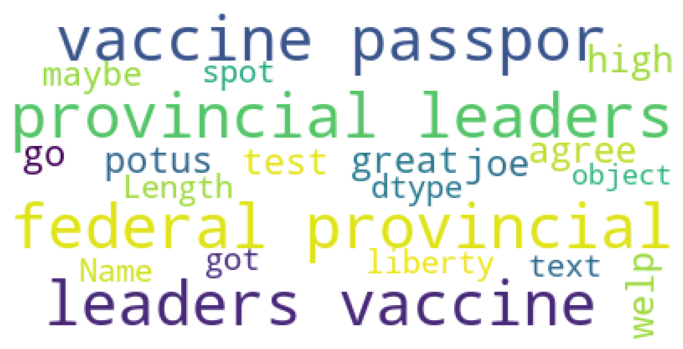

Delta  Topic  7


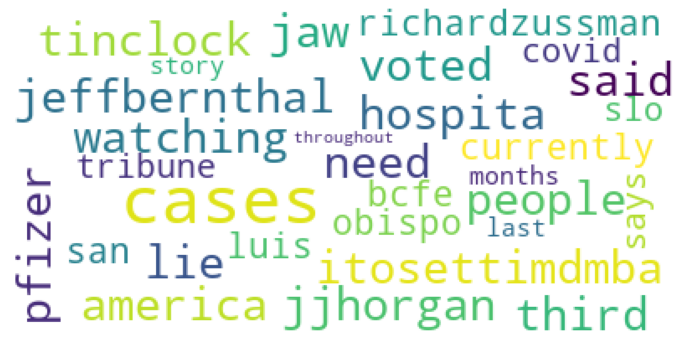

Start  Topic  0


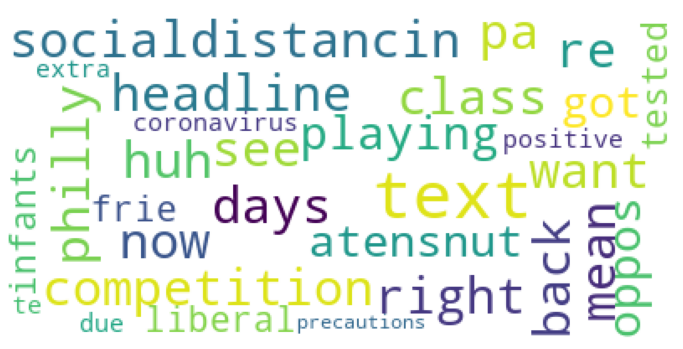

Start  Topic  1


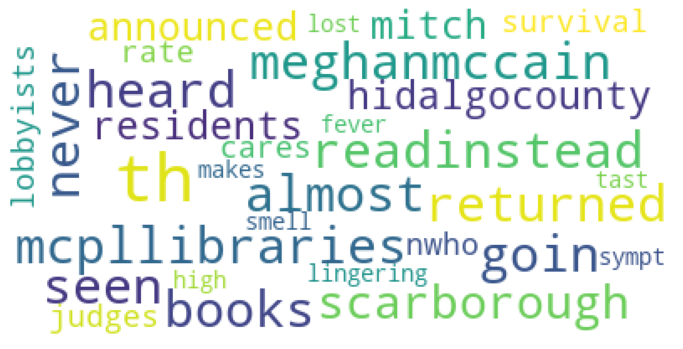

Start  Topic  2


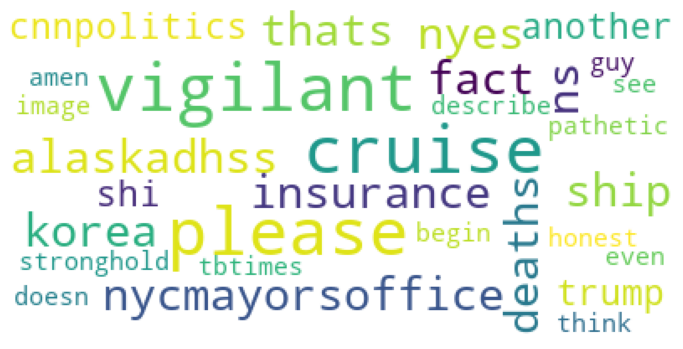

Start  Topic  3


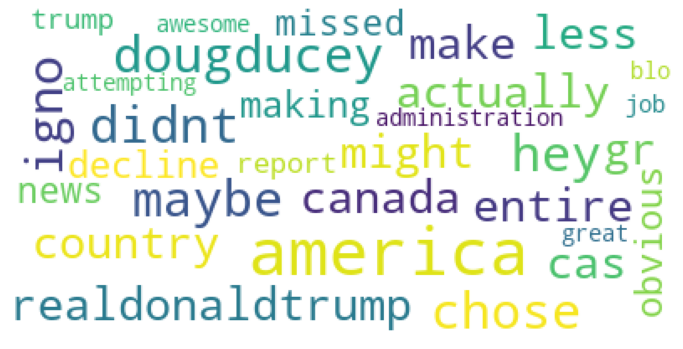

Start  Topic  4


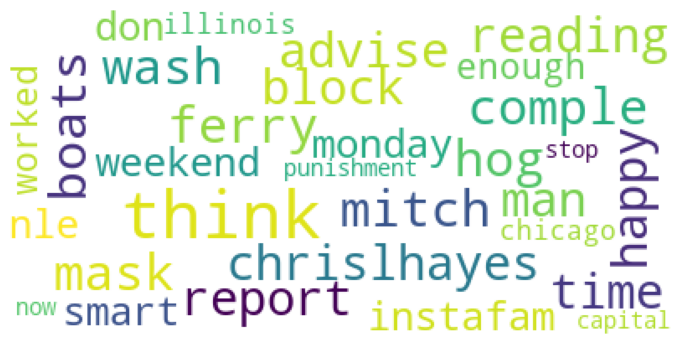

Start  Topic  5


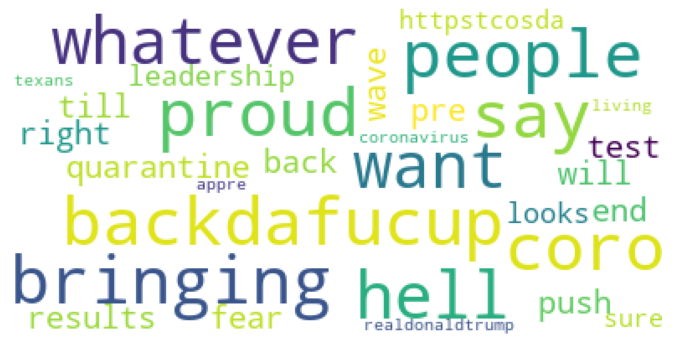

Start  Topic  6


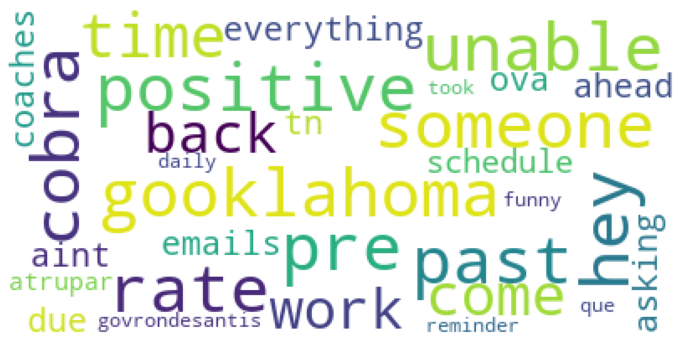

Start  Topic  7


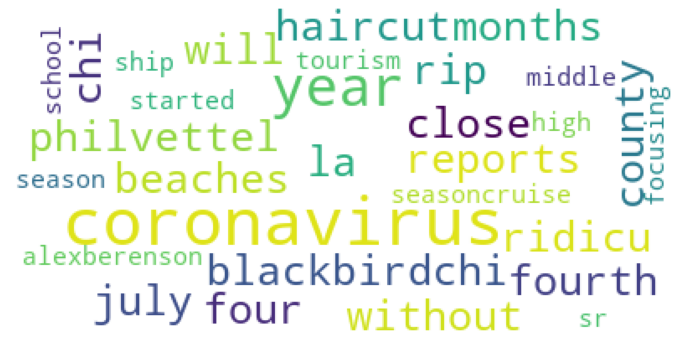

In [ ]:
for i in range(3):
  if i == 0:
    a = 'Vaccines'
  elif i == 1:
    a = 'Delta'
  else:
    a = 'Start'
  for j in range(8):
    import matplotlib as mpl
    from subprocess import check_output
    from wordcloud import WordCloud, STOPWORDS
    mpl.rcParams['figure.figsize']=(12.0,12.0)  
    mpl.rcParams['font.size']=12            
    mpl.rcParams['savefig.dpi']=100             
    mpl.rcParams['figure.subplot.bottom']=.1 
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(
                              background_color='white',
                              stopwords=stopwords,
                              max_words=30,
                              max_font_size=40, 
                              random_state=100
                            ).generate(str(main_df.loc[(main_df['dataset'] == a) & (main_df['topic'] == j)].text))
    print(a, " Topic ", j)
    print(wordcloud)
    fig = plt.figure(1)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show();

In [ ]:
main_df[['text','sentiment','date']].loc[(main_df['dataset'] == 'Start') & (main_df['sentiment'] > 0)].iloc[37]

text         and electrocardiographic and echocardiographic...
sentiment                                               0.6597
date                                       2020-06-30 00:00:00
Name: 104, dtype: object

In [ ]:
from google.colab import files
ulpoaded = files.upload()

Saving main_df.csv to main_df.csv


In [ ]:
!pip uninstall pandas
!pip install pandas

Found existing installation: pandas 1.1.5
Uninstalling pandas-1.1.5:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/pandas-1.1.5.dist-info/*
    /usr/local/lib/python3.7/dist-packages/pandas/*
Proceed (y/n)? y
  Successfully uninstalled pandas-1.1.5
     |████████████████████████████████| 11.3 MB 8.8 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas~=1.1.0; python_version >= "3.0", but you have pandas 1.3.5 which is incompatible.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import io
df = pd.read_csv(io.BytesIO(ulpoaded['main_df.csv']))

ParserError: ignored

In [ ]:
import csv
with open(r"/content/main_df.csv", 'rb') as f:
    reader = csv.reader(f)
    linenumber = 1
    try:
        for row in reader:
            linenumber += 1
    except Exception as e:
        print (("Error line %d: %s %s" % (linenumber, str(type(e)), getattr(e, 'message', ''))))

Error line 1: <class '_csv.Error'> 


In [ ]:
grouped_multiple = main_df.groupby(['dataset', 'date', 'topic']).agg({'sentiment': ['mean', 'min', 'max']})

NameError: ignored

In [ ]:
grouped_multiple

In [ ]:
# draw lineplot
plt.figure(figsize=(10,4))
ax = plt.gca
df.loc[(df['dataset']=="Start") & (df['topic'] == 0)].groupby(['date','sentiment'])['sentiment'].mean().plot(kind='line',x='date', y='sentiment', ax = ax)
df.loc[(df['dataset']=="Start") & (df['topic'] == 1)].groupby(['date','sentiment'])['sentiment'].mean().plot(kind='line',x='date', y='sentiment', color='red',ax = ax)
plt.xlabel("Date")
plt.ylabel("Sentiment")
plt.title("Sentiment by Date, 6/30/2020-7/18/2020")
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.show()